In [1]:
%load_ext autoreload
%autoreload 2

In [28]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import yaml

from typing import List, Dict, Any
from pathlib import Path


# local imports
from src.data_processing.model_analyzers.elastic_net_analyzers.elastic_net_analyzer import MetricAnalyzer, FeatureImportanceAnalyzer
from src.data_processing.model_analyzers.elastic_net_analyzers.path_finder import PathFinder

# Dopamine Only


da_only_path = '/projects/p31961/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg'
da_experimenter = XGBRegExperimenter(da_only_path, analyzer=XGBRegAnalyzer, results = XGBRegrResults)
da_experimenter.run_experiment(
    number_of_runs=20, cls_to_drop=['mouse_id', 'day'])

da_w_day_experimenter = XGBRegExperimenter(
    da_only_path, analyzer=XGBRegAnalyzer, results=XGBRegrResults)
da_w_day_experimenter.run_experiment(
    number_of_runs=20, cls_to_drop=['mouse_id'])

# analyzer.fit_best_xgb_model()
# analyzer.plot_model_results()
# 

In [34]:

da_path = Path(
    '/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg')
path_finder = PathFinder(da_path)

path_finder.metrics_paths

[PosixPath('/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/xgb_regression_da_only_hyperopt_elastic_net/with_day_experiment_results/metric_results.parquet'),
 PosixPath('/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/xgb_regression_da_only_hyperopt_elastic_net/with_out_day_experiment_results/metric_results.parquet'),
 PosixPath('/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/with_day_experiment_results/metric_results.parquet'),
 PosixPath('/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/with_out_day_experiment_results/metric_results.parquet')]

In [43]:
metrics_test = path_finder.metrics_paths[0]
feature_test = path_finder.feature_importance_paths[0]
feature_analyzer = FeatureImportanceAnalyzer(feature_test)
net_analyzer = MetricAnalyzer(metrics_test)


In [41]:
net_analyzer.read_and_clean_data()
df = net_analyzer.data_frame

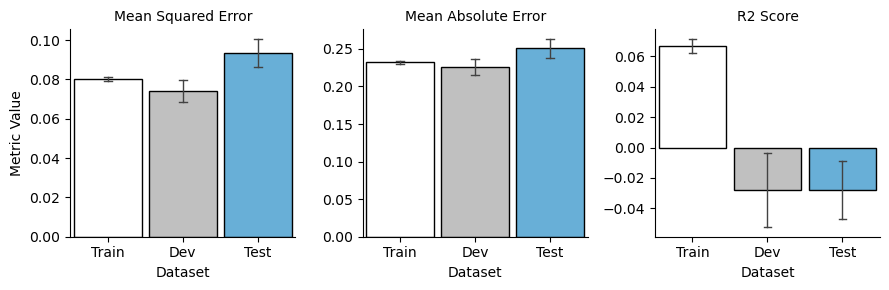

In [42]:
net_analyzer.plot_data(df)

In [50]:
feature_analyzer.read_and_clean_data()
feature_analyzer.data_frame.query("feature=='Day'")

,feature,importance,data_cat,with_day,is_net


In [82]:
path = '/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_and_d1_only_hyperopt_tune_no_reg/xgb_regression_da_and_d1_elastic_net/with_out_day_experiment_results/feature_importance_results.parquet'
df = pd.read_parquet(path)
df.query("feature=='day'")

,feature,importance
0,day,0.124782
0,day,0.129978
0,day,0.059107
0,day,0.060837
0,day,0.099102
0,day,0.145542
0,day,0.120118
0,day,0.130776
0,day,0.234382
0,day,0.232665
